In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import *
from tqdm import tqdm
from numba import njit

def add_periodic_boundaries(arr):
    # takes an (n-2, m-2) array and returns (n, m) array
    rows, cols = arr.shape
    output = np.zeros((rows+2, cols+2), dtype=arr.dtype)

    # Fill the output array with the periodic boundaries
    output[1:-1, 1:-1] = arr # center
    output[0:1, 1:-1] = arr[-1:,:] # first row
    output[-1:, 1:-1] = arr[0:1,:] # last row
    output[1:-1, 0:1] = arr[:,-1:] # first column
    output[1:-1, -1:] = arr[:,0:1] # last column

    return output

plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.dpi"] = 100
plt.set_cmap("binary_r")

<Figure size 1400x800 with 0 Axes>

# Random initialization

In [2]:
np.random.seed(42)

n, m = 34, 43 # dimension of the grid

# Evolution rule: excited -> refractor -> rest (condition) -> excited
rest = 0
excited_spectrum = [1] # may add arbitrary number of integers in ascending order
refractor = excited_spectrum[-1] + 1

@njit
def excite(s_prev, 
           rest=rest, 
           excited=excited_spectrum[0]): 
    # rest -> excited according to von Neumann neighborhood condition
    # by default the ground state is excited
    
    s_next = np.infty * np.ones_like(s_prev)
    n, m = s_prev.shape
    for i in range(1, n-1):
        for j in range(1, m-1):
            if s_prev[i, j] == rest:
                # Stores the values of Von Neumann neighborhood around coordinate (i,j). 
                # This occurs for the previous state
                neighborhood = np.array([
                    s_prev[i-1, j], s_prev[i, j-1], s_prev[i, j+1], s_prev[i+1, j]
                ])
                
                # Checks if there is at least one excited state in the neighbor. 
                if np.sum(neighborhood == excited) >= 1:
                    s_next[i, j] = excited
                else:
                    s_next[i, j] = rest
            else:
                s_next[i, j] = s_prev[i, j]
    return s_next

# The GHCA map for some configuration s_initial
# T is the maximum number of iterations, the function will terminate early if the systems dies or starts to oscillate.
def time_evolution(s_initial, T=1, message=True): 
    """
    Takes some initial configuration (s_initial) and returns the time evolution 
    of the system (results) until some periodic oscillation occurs.
    """
    results = np.zeros([T, *s_initial.shape])
    prev_states = []

    # Loop for time evolution of the system
    for t in range(T):
        results[t] = s_initial
        prev_states.append(s_initial)
        
        # excitation 
        s_next = excite(s_initial)
        
        # unconditional transition
        # excluding the last element since the transition must correspond to last excited -> refractor
        for prev_state, next_state in zip(
            excited_spectrum[:-1], 
            np.roll(excited_spectrum, shift=-1)[:-1]):
            
            s_next[s_initial == prev_state] = next_state # updating the excited states
        
        s_next[s_initial == excited_spectrum[-1]] = refractor # last excited state -> refractor
        s_next[s_initial == refractor] = rest # refractor -> rest
        s_initial = s_next # update s_initial to be the evolved state
        
        # Check for periodicity
        for i, prev_state in enumerate(prev_states):
            if np.allclose(s_next, prev_state):
                periodicity = t - i + 1
                if message:
                    print(f"At transient time t={t+1}, the system reached a periodic state with {periodicity=}.")
                break
        else:
            continue

        break

    return results[:(t+1)].astype(np.float64) # (transient time, n+1, m+1)

                
# initial state, the boundaries are padded with infinities
s1 = np.infty * np.ones([n+2,m+2]) # add 2 because the extra correspond to infinity boundary
# Adding periodic boundary before the infinity
s1[1:-1,1:-1] = add_periodic_boundaries(
    np.random.choice([rest] + excited_spectrum + [refractor], 
                     size=[n-2, m-2], # subtracting 2 because of periodic boundaries is adding 2
                     p=(refractor+1) * [1/(refractor+1)] # default to be uniform distributed
    ) 
)

# creating a similar configuration
s2 = s1.copy() 
s2[n//2, m//2] = (s1[n//2, m//2] + 1) % 2 # shifts the values for one cell

results1 = time_evolution(s1, 100)
results2 = time_evolution(s2, 100)

At transient time t=39, the system reached a periodic state with periodicity=3.
At transient time t=39, the system reached a periodic state with periodicity=3.


# Custom initialization

In [3]:
def generate_matrices():
    matrices = []

    for a in range(3):
        for b in range(3):
            for c in range(3):
                for d in range(3):
                    matrix = np.array([[a, b], [c, d]])
                    matrices.append(matrix)

    return matrices

def filter_matrices(matrices, a, b, c):
    filtered_matrices = []

    for matrix in matrices:
        # Check horizontal and vertical neighbors
        neighbors = (matrix[0, 0] == a and matrix[0, 1] == a) or \
                    (matrix[1, 0] == a and matrix[1, 1] == a) or \
                    (matrix[0, 0] == a and matrix[1, 0] == a) or \
                    (matrix[0, 1] == a and matrix[1, 1] == a)

        # Check if the matrix contains b and c
        contains_b_and_c = (b in matrix.flatten()) and (c in matrix.flatten())

        if neighbors and contains_b_and_c:
            filtered_matrices.append(matrix)

    return filtered_matrices

matrices = generate_matrices()
matrices0012 = filter_matrices(matrices, 0, 1, 2)
matrices0112 = filter_matrices(matrices, 1, 0, 2)
matrices0122 = filter_matrices(matrices, 2, 1, 0)

In [4]:
initial_config = np.concatenate(matrices0012 + matrices0112 + matrices0122, 0) # definately works
initial_config = initial_config.reshape(12, 8)
n, m = initial_config.shape

s0 = np.infty * np.ones([n+2,m+2])
s0[1:-1,1:-1] = initial_config 

# Evolution rule: excited -> refractor -> rest (condition) -> excited
rest = 0
excited_spectrum = [1]
refractor = excited_spectrum[-1] + 1

T = 100 # time steps
results = np.infty * np.ones([T, n+2, m+2])
prev_states = []

@njit
def excite(s0, 
           rest=rest, 
           excited=excited_spectrum[0]): 
           # rest -> excited according to some condition
           # by default the ground state is excited
    
    s1 = np.infty * np.ones_like(s0)
    for i in range(1, n+1): # n + 2 = include infinity, n + 1 = include periodic boundary
        for j in range(1, m+1):
            if s0[i, j] == rest:
                # Stores the values of Von Neumann neighborhood around coordinate (i,j). 
                # This occurs for the previous state
                neighborhood = np.array([
                    s0[i-1, j], s0[i, j-1], s0[i, j+1], s0[i+1, j]
                ])
                
                # Checks if there is at least one excited state in the neighbor. 
                if np.sum(neighborhood == excited) >= 1:
                    s1[i, j] = excited
                else:
                    s1[i, j] = rest
            else:
                s1[i, j] = s0[i, j]
    return s1


### 1.2 and 3
# Loop for time evolution of the system
for t in tqdm(range(T)):
    results[t] = s0
    prev_states.append(s0)
    
    # excitation with some condition
    s1 = excite(s0)
    
    # unconditional transition
    # excluding the last element since the transition must correspond to last excited -> refractor
    for prev_state, next_state in zip(
        excited_spectrum[:-1], 
        np.roll(excited_spectrum, shift=-1)[:-1]):
        
        s1[s0 == prev_state] = next_state # updating the excited states
    
    s1[s0 == excited_spectrum[-1]] = refractor # last excited state -> refractor
    s1[s0 == refractor] = rest # refractor -> rest
    s0 = s1 # s0 is now the evolved state
    
    # Check for periodicity
    for i, prev_state in enumerate(prev_states):
        if np.allclose(s1, prev_state):
            periodicity = t - i + 1
            print(f"At transient time t={t+1}, the system reached a periodic state with {periodicity=}.")
            break
    else:
        continue

    break
    
results = results[:(t+1)]

 13%|█▎        | 13/100 [00:00<00:02, 39.31it/s]

At transient time t=14, the system reached a periodic state with periodicity=3.


# Visualizations

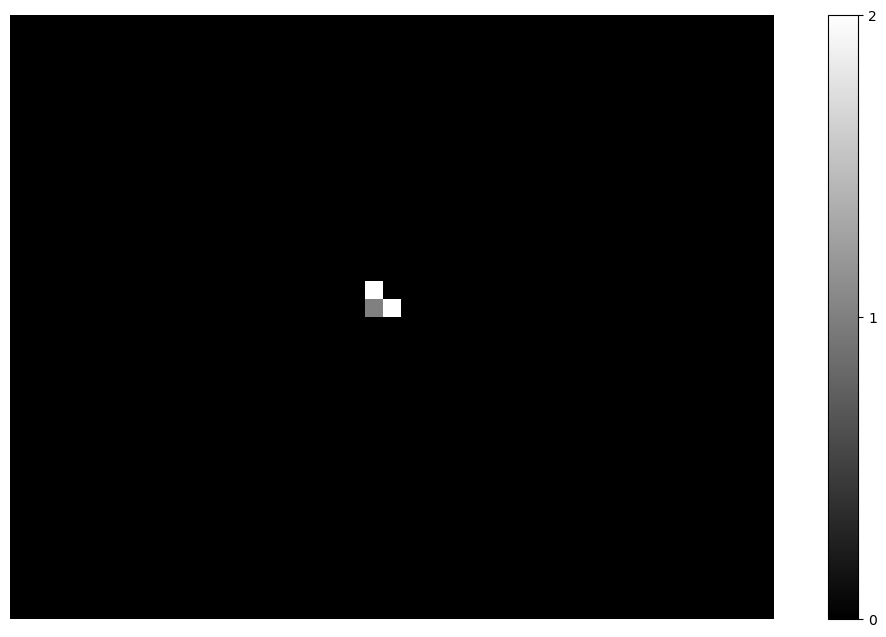

In [5]:
# Simple visualization of the last frame before the oscillation starts to occur.
# The results is cut since the bounds are padded with infinity.
plt.imshow(results1[-1][1:-1,1:-1] - results2[-1][1:-1,1:-1], vmin=0, vmax=refractor)  
plt.colorbar(ticks=[rest] + excited_spectrum + [refractor])
plt.axis("off")
plt.show()

Creating a GIF that visualizes the time evolution of the GHCA for some random uniform configuration.
Result1 and Result2 differs by only one cell at time zero.
The third plot shows the difference between the systems
if it ends up completely black, then we have an attracting configuration. 
However, it looks like there is a non-trivial oscillation pattern in the difference indicating that we have a neutral configuration.
 

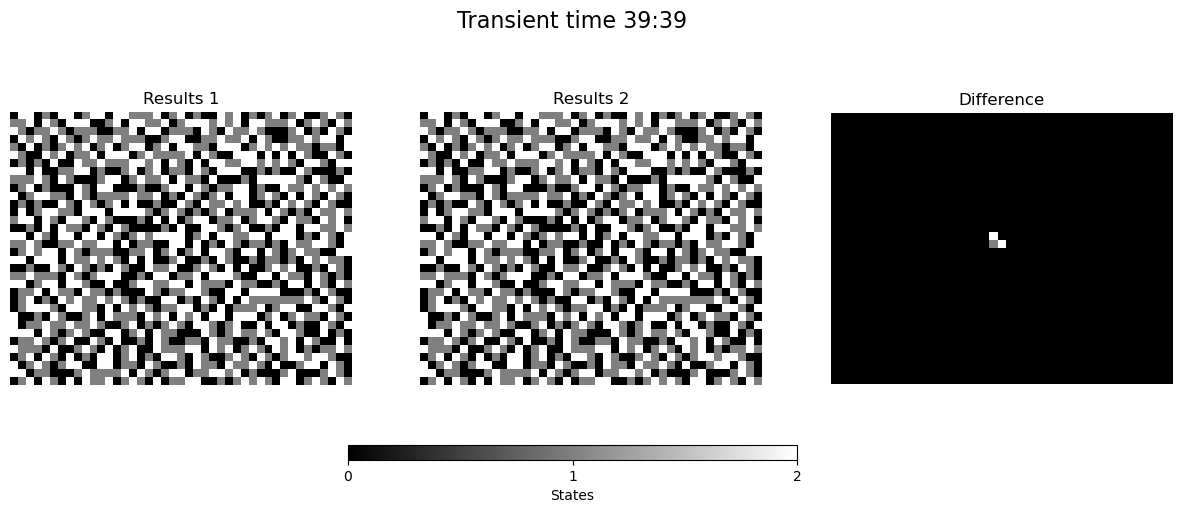

In [6]:
def update_plot(i, ims, results1, results2, diff_results, fig):
    ims[0].set_array(results1[i][1:-1,1:-1])
    ims[1].set_array(results2[i][1:-1,1:-1])
    ims[2].set_array(diff_results[i][1:-1,1:-1])
    fig.suptitle(f'Transient time {i+1}:{len(results1)}', fontsize=16)
    return ims

def create_side_by_side_gif(results1, results2=None, filename='GHCA.gif', duration=100):
    if results2 is None:
        results2 = np.zeros_like(results1)

    T = results1.shape[0]
    diff_results = np.abs(results1[:T,1:-1,1:-1] - results2[:T,1:-1,1:-1])

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    ims = [axes[0].imshow(results1[-1], animated=True, vmin=0, vmax=refractor),
           axes[1].imshow(results2[-1], animated=True, vmin=0, vmax=refractor),
           axes[2].imshow(diff_results[-1], animated=True)]

    for ax, title in zip(axes, ['Results 1', 'Results 2', 'Difference']):
        ax.set_title(title)
        ax.axis("off")

    # Add a horizontal colorbar at the bottom
    cbar_ax = fig.add_axes([0.35, 0.08, 0.3, 0.03])
    cbar = fig.colorbar(ims[0], cax=cbar_ax, ticks=[rest] + excited_spectrum + [refractor], orientation='horizontal')
    cbar.set_label("States")

    ani = FuncAnimation(fig, update_plot, frames=range(T), 
                        fargs=(ims, results1, results2, diff_results, fig), 
                        interval=duration, blit=True)
    ani.save(filename, writer='pillow', fps=1)


create_side_by_side_gif(results1, results2, duration=100)

# Direct proof of additivity of GHCA
The code begins by producing the set of 3 by 3 "plus sign"-configurations. This can be seen as a subset of 3 by 3 matrices with 0, 1, 2 and the corners have the value infinity. The reason is to have the same values in the corners when two configurations are added.
Additionally I use a special modulus function that does not touch the infinity at the corners.
If the code runs succesfully, then it proves that any 3 by 3 "plus sign"-configuration satisfies the additivity property of GHCA for rest state 0, excited state 1, and refractor state 2.

In [8]:
# The set of all "plus sign"-configuration with fixed corners (compatible with von Neumann neighborhood)
def generate_matrices(corner_value=-1):
    num_matrices = 4 ** 5
    matrices = np.ones((num_matrices, 3, 3))

    counter = 0
    for b in range(4):
        for d in range(4):
            for e in range(4):
                for f in range(4):
                    for h in range(4):
                        matrix = np.array([[corner_value, b, corner_value], 
                                           [d, e, f], 
                                           [corner_value, h, corner_value]])
                        matrices[counter] = matrix
                        counter += 1

    return matrices

# Function that takes some matrix d1 and d2 and evolves them by one step according to GHCA.
# It then checks the additivity property of the map.
def check_additivity(d1, d2, message=False):
    
    RHS = mod(
        time_evolution(d1, 1, message)[0] + time_evolution(d2, 1, message)[0]
    )
    
    LHS = time_evolution( 
        mod(d1 + d2), 1, message
    )[0]
    
    return np.allclose(RHS, LHS)

# special mod function that only performs the modulus for finite values
def mod(x, value=2): 
    x[x != np.infty] %= value
    return x


# The set of all possible "plus sign"-configurations
matrices = generate_matrices() 
matrices[matrices == -1] = np.infty 
N = len(matrices)

for i in tqdm(range(N)):
    for j in range(i, N):
        d1 = matrices[i]
        d2 = matrices[j]
        
        if not check_additivity(d1, d2):
            print("Conjecture disproved")
            break

else: # message is printed if and only if the loop is completed without early break
    print("Conjecture proved")

100%|██████████| 1024/1024 [04:35<00:00,  3.72it/s]

Conjecture proved
